# Non-Cartesian T1 | Subspace-Constrained Reconstruction
This tutorial uses the [`BART`](http://mrirecon.github.io/bart/) command-line interface (CLI) and presents how to work with radial data using BART, with the goal of implementing a full processing pipeline from raw data to T1 maps.


## Outline
1. Bart Setup
2. Simulation IR radial FLASH
4. Reconstruction Simulation PICS?
5. Prepare Subspace Reconstruction
   1. Subspace basis generation
    6. Subspace reconstruction
    7. Postprocessing


**Author**: [Vitali Telezki](mailto:vitali.telezki@med.uni-goettingen.de)

**Institution**: University Medical Center Göttingen

Based on previous material written by [Daniel Mackner](mailto:daniel.mackner@tugraz.at), [Moritz Blumenthal](mailto:blumenthal@@tugraz.at) and [Jon Tamir](mailto:jtamir@utexas.edu)



In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import src.plotSubspace as ps
import numpy as np
import importlib

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['ggplot', 'src/customStyle.mplstyle'])

## Bart Setup Check


In [2]:
%%bash
echo "# BART used in this notebook:"
which bart
echo "# BART version: "
bart version

# BART used in this notebook:
/home/vtelezki/Repos/Groups/AG_Uecker/barts/bart/bart
# BART version: 
v0.9.00-1128-g995d362


## Simulation: inversion-prepared radial FLASH 
Using `bart phantom`, we will create a a numerical phantom with the inversion-prepared radial FLASH sequence with the following parameters. We use `bart signal` to simulate signal curves from individual vials and background and join them in one file

In [3]:
%%bash
# Define Sequence Parameters
TR=0.006 # [s]
DIM=384 # Readouts
SPOKES=1
REP=700 # Repetitions
NC=8 # Number of Coils
BR=$((DIM/2)) # Base resolution, as DIM includes two-fold oversampling

# create trajectory
bart traj -x $DIM -y $SPOKES -t $REP -c -r -G - | bart transpose 5 10 - tmp_traj
bart scale 0.5 tmp_traj traj

echo dimensions of trajectory
head -n2 traj.hdr

# create geometry basis functions
bart phantom -s$NC -T -k -b -t traj tmp_basis_geom
#create phantom in plane mask 
bart phantom -x $BR -T roi_mask

# check the dimensions
echo dimensions of geometry basis functions
head -n2 tmp_basis_geom.hdr

# create signal tubes and background
bart signal -F -I -n$REP -r$TR  -1 0.2:2.2:10 -2 0.045:0.045:1 tmp_basis_simu_tubes
bart signal -F -I -n$REP -r$TR  -1 3:3:1 -2 1:1:1 tmp_basis_simu_water

bart join 6 tmp_basis_simu_water tmp_basis_simu_tubes tmp_basis_simu
# check the dimensions
echo dimensions of signal basis functions
head -n2 tmp_basis_simu.hdr

dimensions of trajectory
# Dimensions
3 384 1 1 1 700 1 1 1 1 1 1 1 1 1 1 
dimensions of geometry basis functions
# Dimensions
1 384 1 8 1 700 11 1 1 1 1 1 1 1 1 1 
dimensions of signal basis functions
# Dimensions
1 1 1 1 1 700 11 1 1 1 1 1 1 1 1 1 


In [4]:
%%bash
# create simulated dataset
bart fmac -s $(bart bitmask 6) tmp_basis_geom tmp_basis_simu simu_ksp

# add noise to the simulated dataset 
# bart noise -n1 simu_ksp simu_ksp
# check the dimensions
echo dimensions of simulated phantom 
head -n2 simu_ksp.hdr

## remove tmp files
rm tmp_*

dimensions of simulated phantom
# Dimensions
1 384 1 8 1 700 1 1 1 1 1 1 1 1 1 1 


## Subspace Reconstruction
Now, we aim to reconstruct the simulated phantom data. First, we create a signal dictionary, then we perform a SVD and finally create the temporal basis used in subspace reconstruction.

The signal model according to Look-Locker in voxel $r$ at time $t$ is
$$ 
M(t,r)~=~M_{ss}(r)~-~\left[M_{ss}(r)~+~M_{0}(r)\right]~e^{-tR_1^*(r)}.~
$$


In [5]:
%%bash 
bart show -m simu_ksp

Type: complex float
Dimensions: 16
AoD:	1	384	1	8	1	700	1	1	1	1	1	1	1	1	1	1


### Create Signal Dictionary
Using `bart signal` we create our signal dictionary with `nR1s` values for R1star and `nMss` values for steady-state magnetization. 

In [6]:
%%bash
## signal parameter
nR1s=1000
nMss=100 
REP=700
TR=0.006

bart signal -help

bart signal -F -I -n $REP -r $TR -1 5e-3:5:$nR1s -3 1e-2:1:$nMss tmp_dict
# reshape the dicc to have all the elements on the 6th dimension
bart reshape $(bart bitmask 6 7) $((nR1s * nMss)) 1 tmp_dict tmp_dict1
head -n2 tmp_dict1.hdr
# squeeze the dicc1 before SVD
bart squeeze tmp_dict1 subspace_dict
head -n2 subspace_dict.hdr
# perform SVD on dictionary
bart svd -e subspace_dict U S V

Usage: signal [-F] [-B] [-T] [-S] [-M] [-G] [-C] [-A] [--fat] [-I] [-s] [--short-TR-LL-approx] [-0 f:f:f] [-1 f:f:f] [-2 f:f:f] [-3 f:f:f] [-4 f:f:f] [-5 f:f:f] [-6 f:f:f] [-r f] [-e f] [-i f] [-f f] [-d f] [-t f] [-n d] [-b d] [--av-spokes d] [-m d] [--freq-samples d] [--pulsed] [-l f] [-a f] [--acquisition-only] <basis-functions> 

Analytical simulation tool.

-F                      FLASH
-B                      bSSFP
-T                      TSE
-S                      SE
-M                      MOLLI
-G                      MGRE
-C                      IR MGRE
-A                      ASL
--fat                   Simulate additional fat component.
-I                      inversion recovery
-s                      inversion recovery starting from steady state
--short-TR-LL-approx    Short TR approximation for analytical LL model.
-0 min:max:N            range of off-resonance frequency [Hz]
-1 min:max:N            range of T1s [s]
-2 min:max:N            range of T2s [s]
-3 min:max:N 

### Visualize simulated dictionay and PCA coeffcients

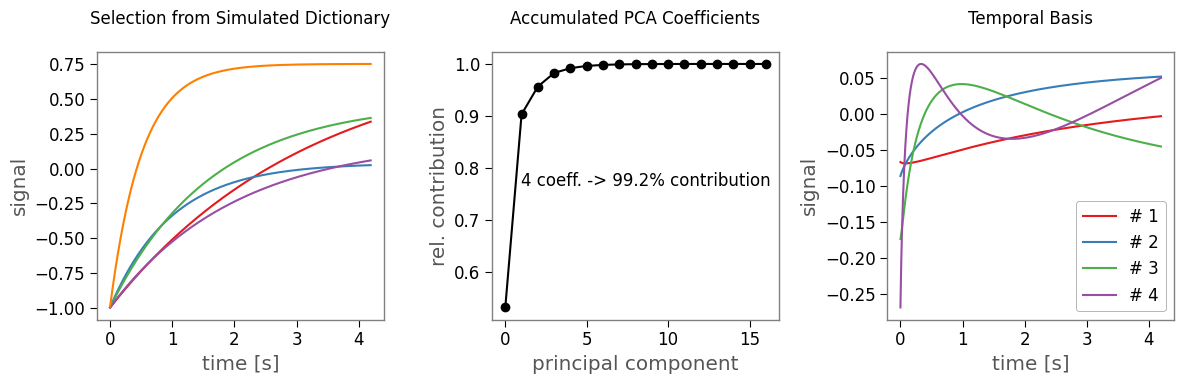

In [11]:
importlib.reload(ps)
ps.plotSubspace()


### Estimate Coil Sensitivities Using Subspace
We realized, that 4 PCA coefficients contribute to more than 99% of the observed signal. Hence, we can reduce our basis to only contain the first 4 eigenvectors. We create a subspace basis spanned by those 4 eigenvectors.


In [12]:
%%bash

nCoe=4 # use 4 coefficients

# create the temporal basis
bart extract 1 0 $nCoe U subbasis
# transpose the basis to have time on the 6th dimension and coefficients on the 5th dimension
bart transpose 1 6 subbasis - | bart transpose 0 5 - subbasis 
head -n2 subbasis.hdr

# Dimensions
1 1 1 1 1 700 4 1 1 1 1 1 1 1 1 1 



 Now, we estimate coil sensitivities using `bart ncalib` and reduced subspace basis in one go. 

In [13]:
%%bash
DEBUG_LEVEL=4 bart ncalib -N -i8 -t traj -B subbasis simu_ksp sens_ncalib

Est. image size: 192 192 1
ksp : [  1 384   1   8   1 700   1   1   1   1   1   1   1   1   1   1 ]
cim : [ 48  48   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384   1   1   1 700   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 384   1   1   1 700   1   1   1   1   1   1   1   1   1   1 ]
bas : [  1   1   1   1   1 700   4   1   1   1   1   1   1   1   1   1 ]
NUFFT: low-mem mode
NUFFT: Toeplitz mode

Model created (non Cartesian, nufft-based):
kspace:     [  1 384   1   8   1 700   1   1   1   1   1   1   1   1   1   1 ]
images:     [ 48  48   1   1   1   1   4   1   1   1   1   1   1   1   1   1 ]
coils:      [ 16  16   1   8   1   1   1   1   1   1   1   1   1   1   1   1 ]
trajectory: [  3 384   1   1   1 700   1   1   1   1   1   1   1   1   1   1 ]
pattern:    [  1 384   1   1   1 700   1   1   1   1   1   1   1   1   1   1 ]
basis:      [  1   1   1   1   1 700   4   1   1   1   1   1   1   1   1   1 ]
mask:       [  1   1   1   1   1   1   1   1   1

### Perform reconstruction 

Using estimated coil sensitvities, we can now perform parrallel imaging reconstruction with `bart pics`.

In [14]:
%%bash

DIM=384 # Readouts
BR=$((DIM/2)) # Base resolution, as DIM includes two-fold oversampling
ITER=100
REG=0.0005
# # reconstruction with subspace constraint
bart pics -g -e -d5 -i $ITER -R W:$(bart bitmask 0 1):$(bart bitmask 6):$REG -B subbasis -t traj simu_ksp sens_ncalib subspace_reco

# resize the coefficient maps to the original size and multiply it with the roi_mask
# bart resize -c 0 $BR 1 $BR subspace_reco - | bart fmac roi_mask - subspace_reco_masked
# visualize subspace maps for 4 nCoe
# bart reshape $(bart bitmask 1 6) $((BR*nCoe)) 1 subspace_reco_masked subspace_maps

Basis: [192 192   1   8   1 700   4   1   1   1   1   1   1   1   1   1 ]
Max:   [192 192   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
GPU reconstruction
[  1 384   1   8   1 700   4   1   1   1   1   1   1   1   1   1 ]
[192 192   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 384   1   8   1 700   4   1   1   1   1   1   1   1   1   1 ]
cim : [192 192   1   8   1   1   4   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384   1   1   1 700   1   1   1   1   1   1   1   1   1   1 ]
wgh : [  1 384   1   1   1 700   1   1   1   1   1   1   1   1   1   1 ]
bas : [  1   1   1   1   1 700   4   1   1   1   1   1   1   1   1   1 ]
NUFFT: Toeplitz mode
psf_dims: [192 192   1   1   1 700   1   1   1   1   1   1   1   1   1   1 ]
ksp : [  1 384   1   1   1 700   1   1   1   1   1   1   1   1   1   1   1 ]
cim : [384 384   1   1   1   1  16   1   1   1   1   1   1   1   1   1   1 ]
traj: [  3 384   1   1   1 700   1   1   1   1   1   1   1   1   1   1   1 ]
wgh :

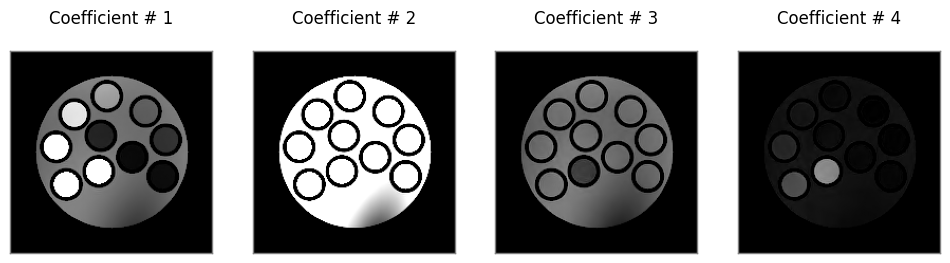

In [15]:
ps.plotCoefficientMaps()


### Temporal Signal Evolution

In [17]:
%%bash 
bart fmac -s $(bart bitmask 6) subbasis subspace_reco imgs

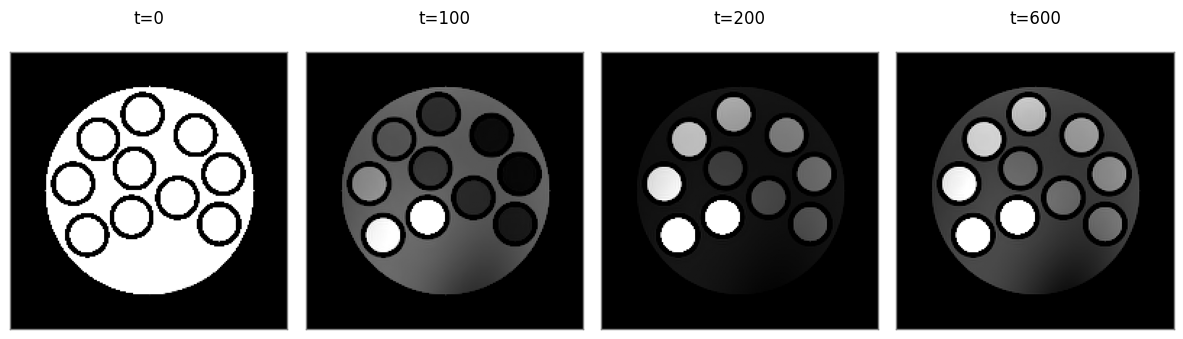

In [18]:
ps.plotTemporalEvolution()


### T1 Map from Reconstructed Images
Using `bart mobafit` we obtain T1 parameter map via pixel-wise fitting. 

In [20]:
%%bash
TR=0.006 # [s]
REP=700 # Repetitions

### create vector with inversion times nREP*TR
bart index 5 $REP - | bart scale $TR - TI

bart mobafit -g -B subbasis -L --init 1:1:1 TI imgs - | bart looklocker -t0 - -| bart fmac roi_mask - t1map

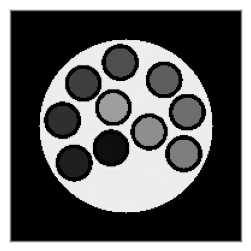

In [21]:
ps.plotT1Map()